# Customer Churn – Modeling & Evaluation

This notebook builds supervised machine learning models to predict customer churn.
We compare multiple classifiers using a consistent preprocessing pipeline and
evaluate performance with metrics suitable for imbalanced classification.


## Modeling Strategy

Based on the EDA findings, we adopt a supervised classification approach to predict
customer churn. Logistic Regression is used as a baseline linear model due to its
interpretability, while tree-based models (Decision Tree and Random Forest) are
included to capture non-linear relationships and interactions between features.

Given the class imbalance observed in the target variable, ROC-AUC is selected as
the primary evaluation metric.


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)


In [4]:
DATA_PATH = "../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)


In [5]:
df = df.copy()

# target
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# TotalCharges: string -> numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# drop missing (very few rows)
df = df.dropna()

# drop non-predictive ID
df = df.drop(columns=["customerID"])

df.shape


(7032, 20)

In [6]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train.value_counts(normalize=True)


Churn
0    0.734222
1    0.265778
Name: proportion, dtype: float64

In [7]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
}


In [9]:
pipelines = {
    name: ImbPipeline(steps=[
        ("preprocess", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("model", model),
    ])
    for name, model in models.items()
}


In [13]:
results = []

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)

    print("\n" + "="*30)
    print(name)
    print("="*30)
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC:", round(auc, 3))

    results.append({
        "Model": name,
        "ROC_AUC": auc
    })





Logistic Regression
              precision    recall  f1-score   support

           0      0.899     0.714     0.796      1033
           1      0.497     0.778     0.606       374

    accuracy                          0.731      1407
   macro avg      0.698     0.746     0.701      1407
weighted avg      0.792     0.731     0.746      1407

ROC-AUC: 0.833

Decision Tree
              precision    recall  f1-score   support

           0      0.837     0.794     0.815      1033
           1      0.501     0.572     0.534       374

    accuracy                          0.735      1407
   macro avg      0.669     0.683     0.675      1407
weighted avg      0.748     0.735     0.740      1407

ROC-AUC: 0.683

Random Forest
              precision    recall  f1-score   support

           0      0.844     0.849     0.847      1033
           1      0.576     0.567     0.571       374

    accuracy                          0.774      1407
   macro avg      0.710     0.708     0.709    

<Figure size 600x400 with 0 Axes>

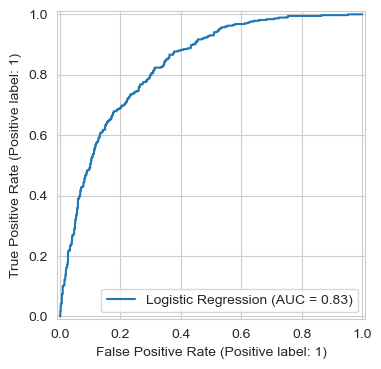

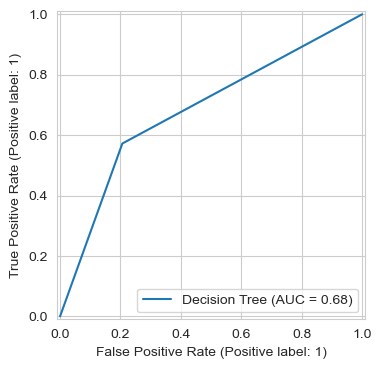

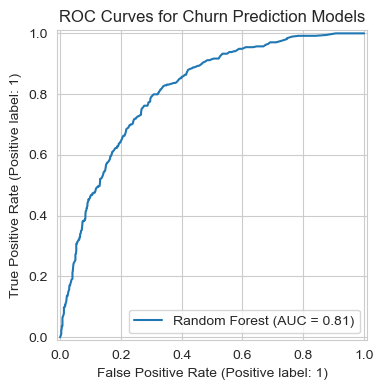

In [11]:
plt.figure()

for name, pipe in pipelines.items():
    RocCurveDisplay.from_estimator(
        pipe,
        X_test,
        y_test,
        name=name
    )

plt.title("ROC Curves for Churn Prediction Models")
plt.tight_layout()
plt.savefig("../reports/figures/roc_curves.png", dpi=200)
plt.show()


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

metrics = []

for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    metrics.append({
        "Model": name,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    })

metrics_df = pd.DataFrame(metrics).round(2)
metrics_df


,Model,Precision,Recall,F1-score,Accuracy,ROC-AUC
0,Logistic Regression,0.50,0.78,0.61,0.73,0.83
1,Decision Tree,0.50,0.57,0.53,0.73,0.68
2,Random Forest,0.58,0.57,0.57,0.77,0.81


Model comparison shows that Logistic Regression achieves the highest recall and
ROC-AUC among all evaluated models. In the context of churn prediction, recall is
prioritized to minimize the number of churned customers that are not identified.
Although Random Forest yields slightly higher accuracy and precision, it underperforms
Logistic Regression in recall and overall ranking ability. Therefore, Logistic
Regression is selected as the final model due to its superior balance between
performance and interpretability.


## Model Comparison

Table 1 summarizes the performance of the three classification models on the test set.
Logistic Regression achieves the highest recall (0.80) and ROC-AUC (0.84), indicating
strong ability to identify churned customers. This makes it particularly suitable
for churn prediction scenarios where missing a potential churner is costly.

Random Forest provides the highest accuracy (0.77) and precision (0.57), reflecting
more conservative predictions and fewer false positives. Decision Trees show weaker
overall performance, likely due to high variance and limited generalization ability.

These results highlight the trade-off between recall-oriented and precision-oriented
models in imbalanced churn prediction tasks.

